In [1]:
## Import the libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score

## Reading the Data

In [2]:
P_W1 = pd.read_csv('Plant_1_Weather_Sensor_Data.csv')
P_G1 = pd.read_csv('Plant_1_Generation_Data.csv')
P_W2 = pd.read_csv('Plant_2_Weather_Sensor_Data.csv')
P_G2 = pd.read_csv('Plant_2_Generation_Data.csv')

print("Done")

Done


                                             |          | [  0%]   00:00 -> (? left)

Report sweetviz_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.



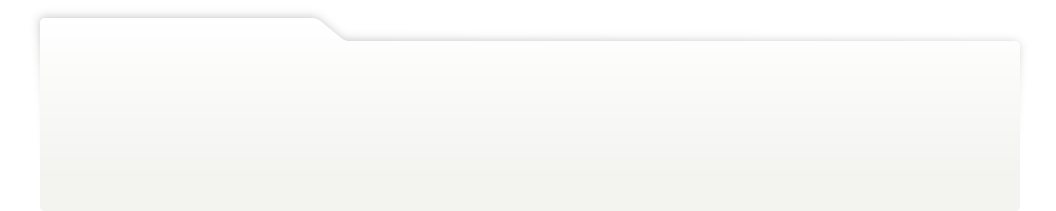
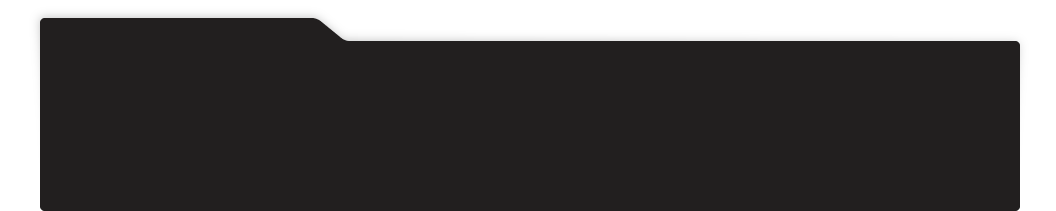
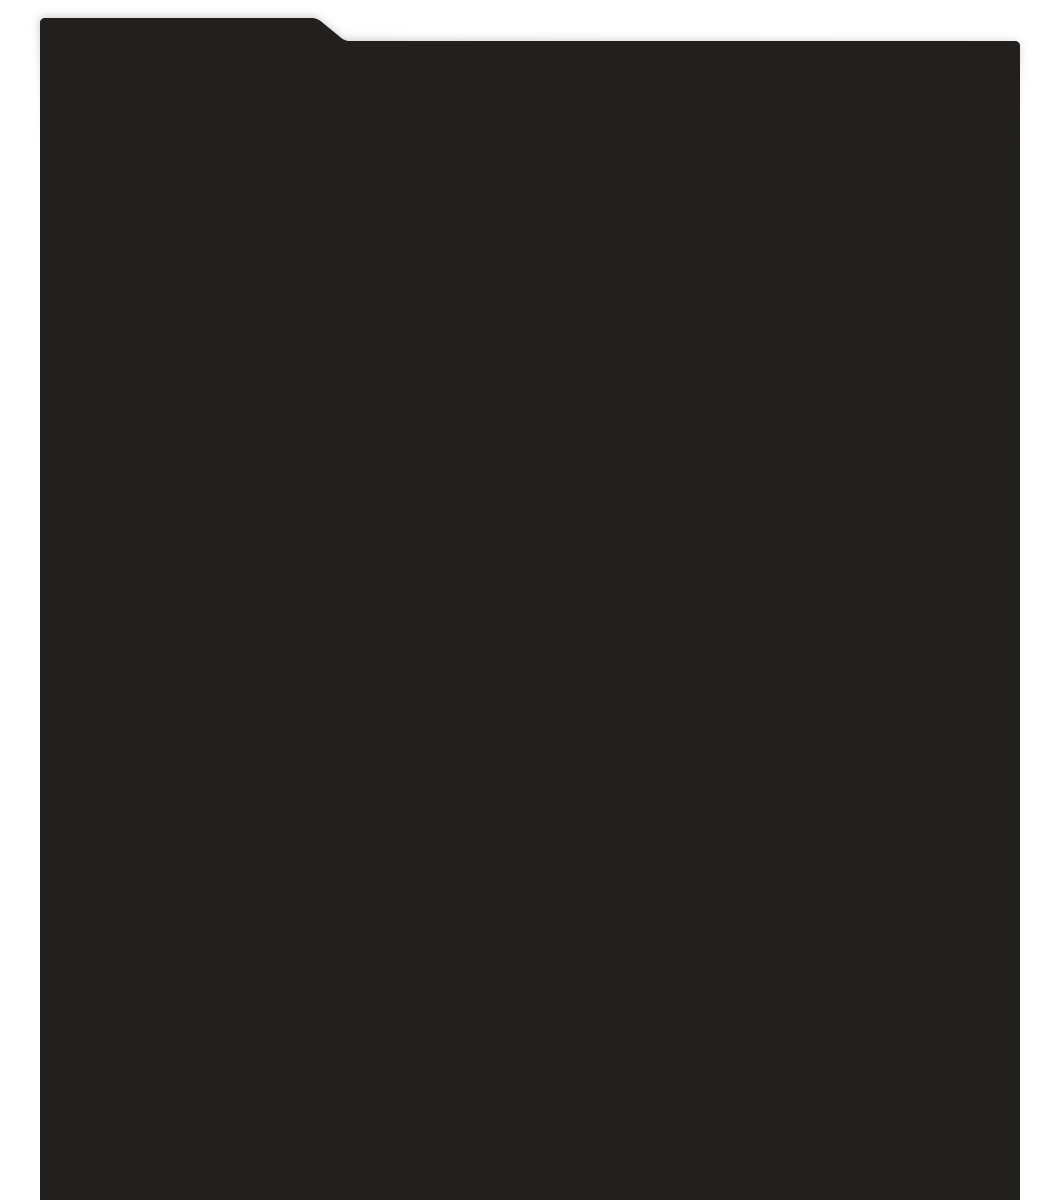
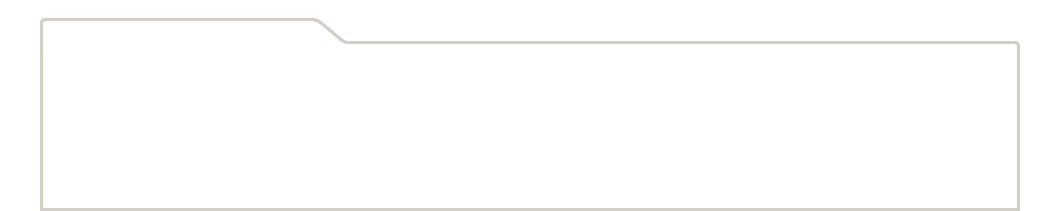
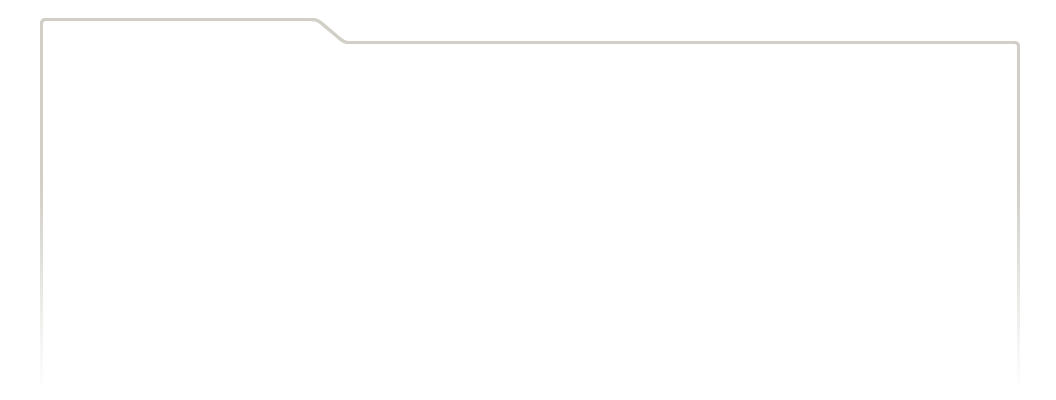
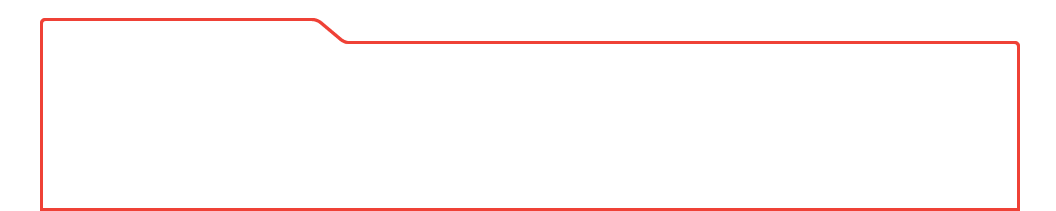
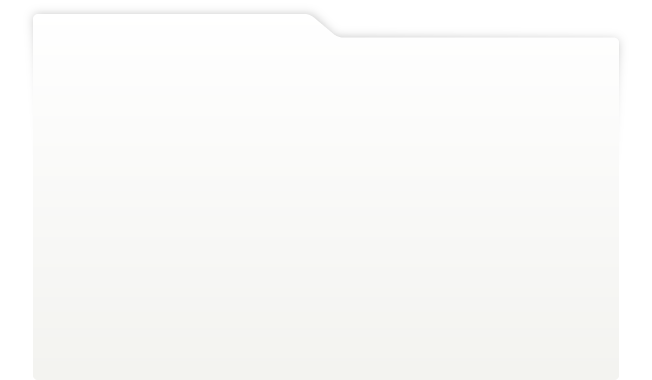
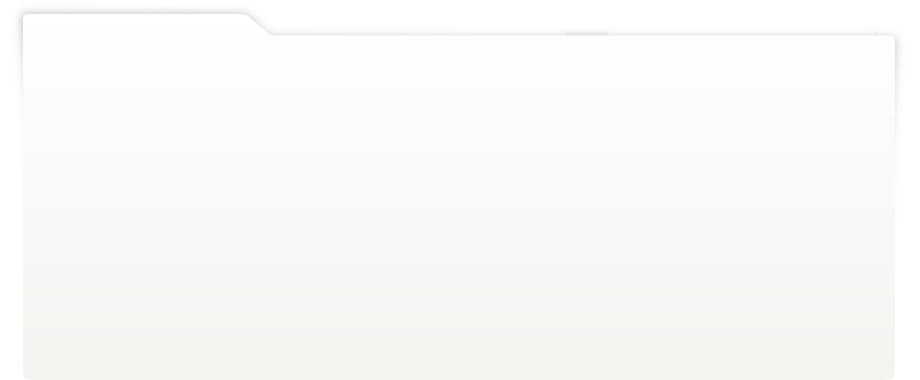
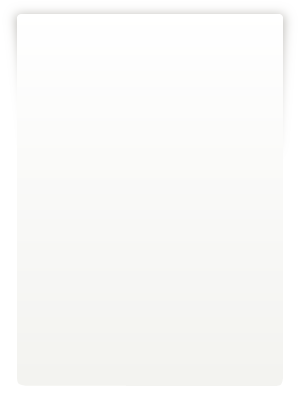
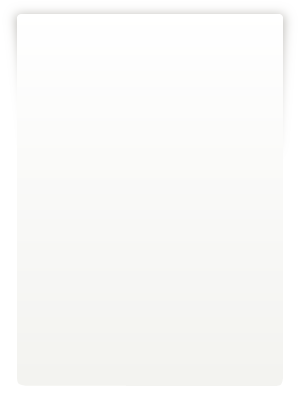
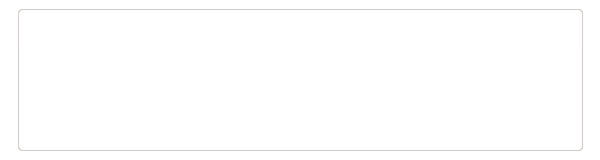
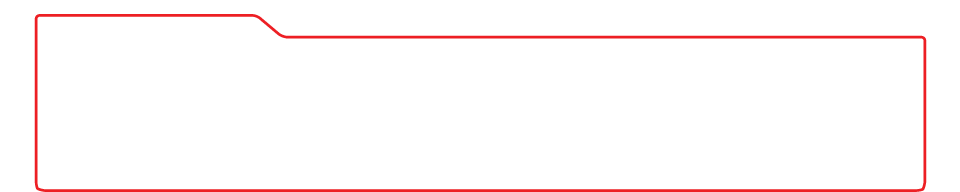
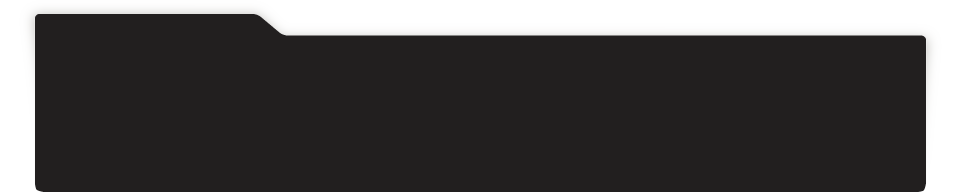
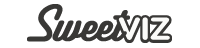
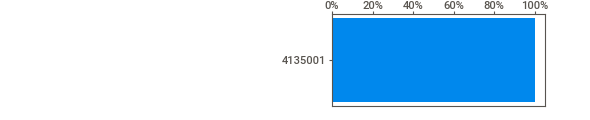
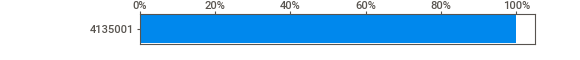
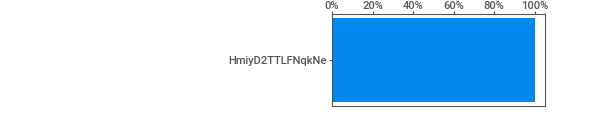
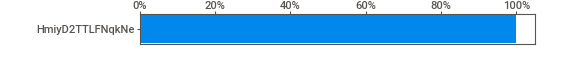
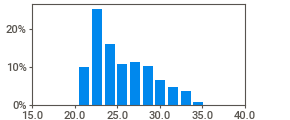
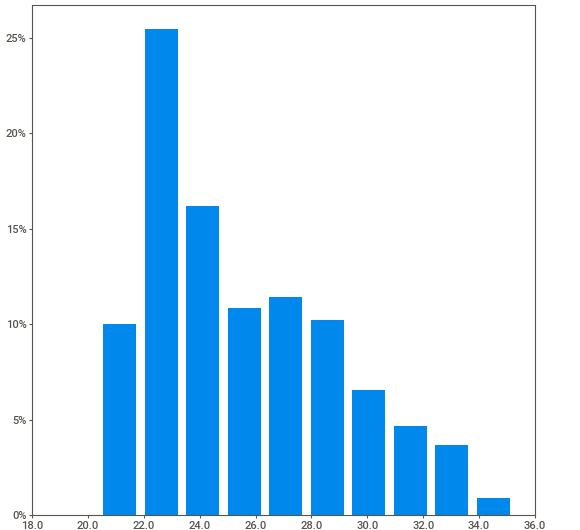
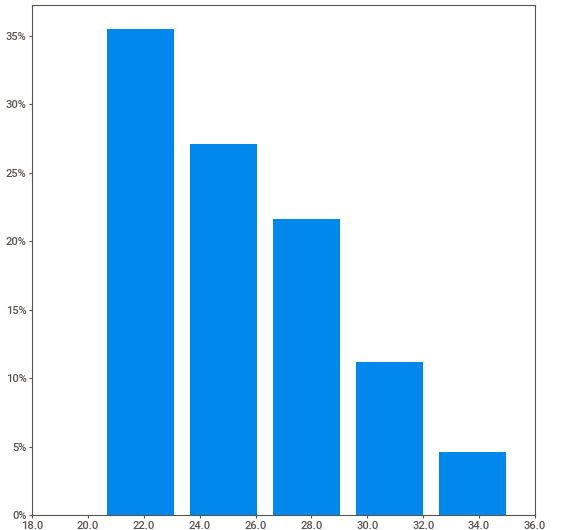
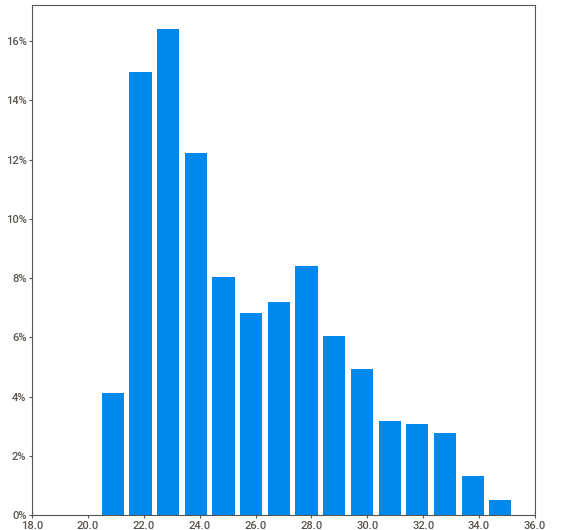
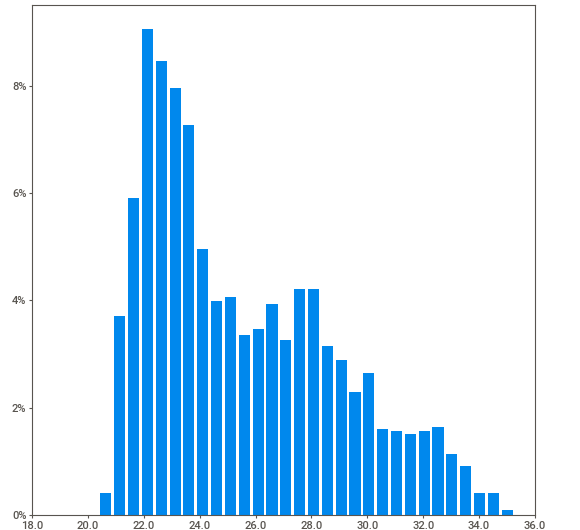
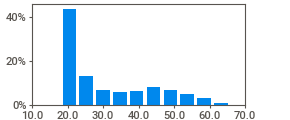
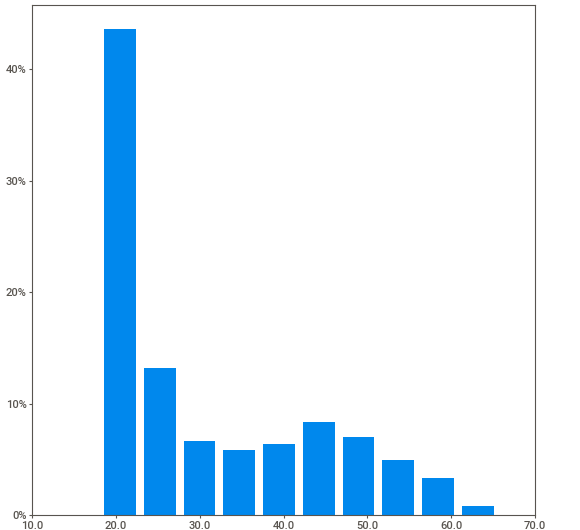
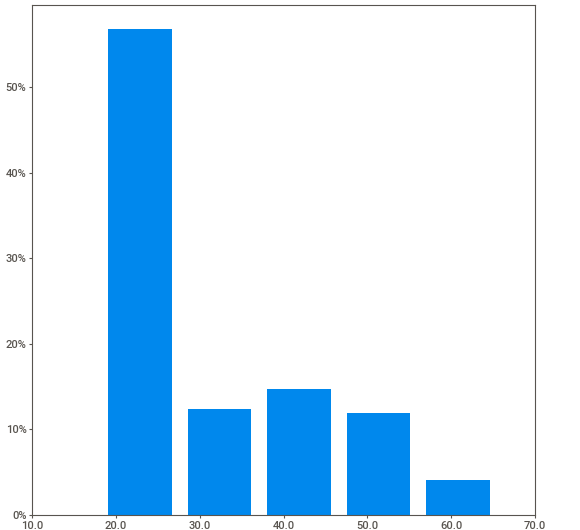
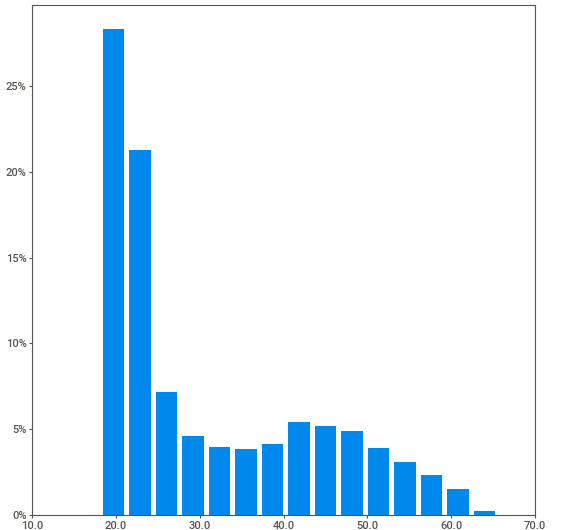
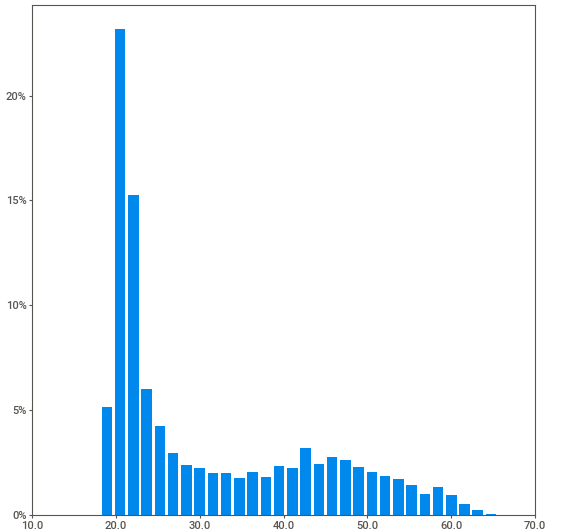
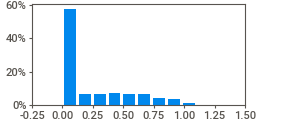
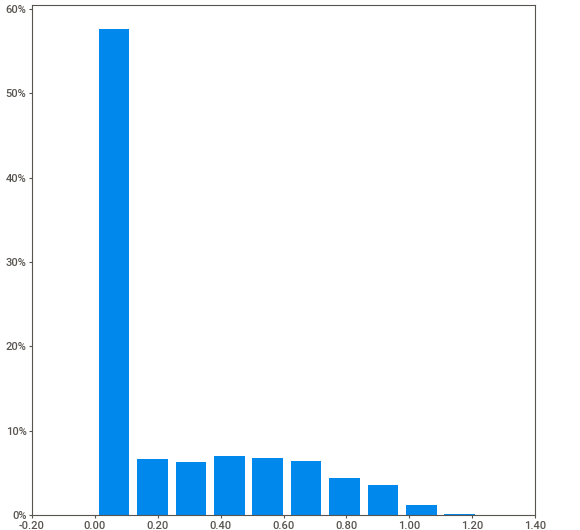
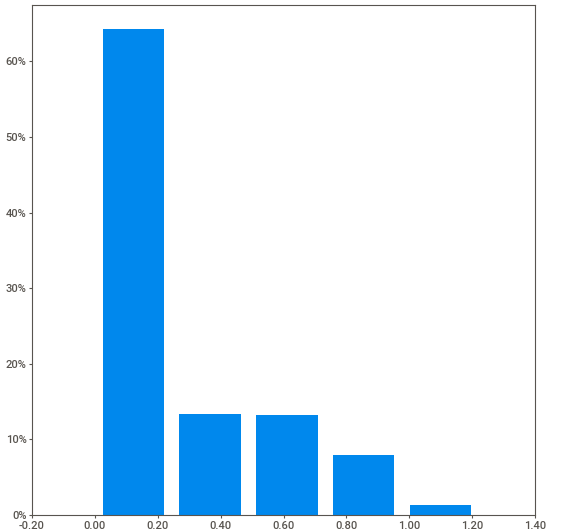
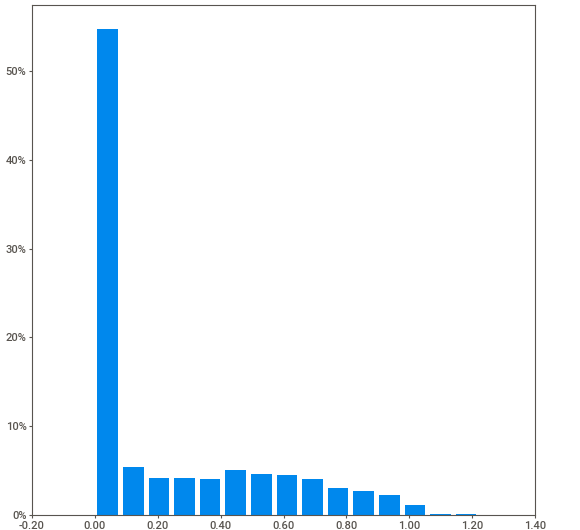
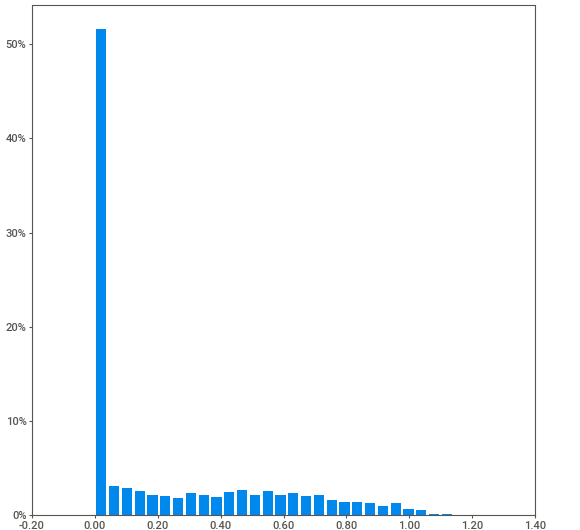
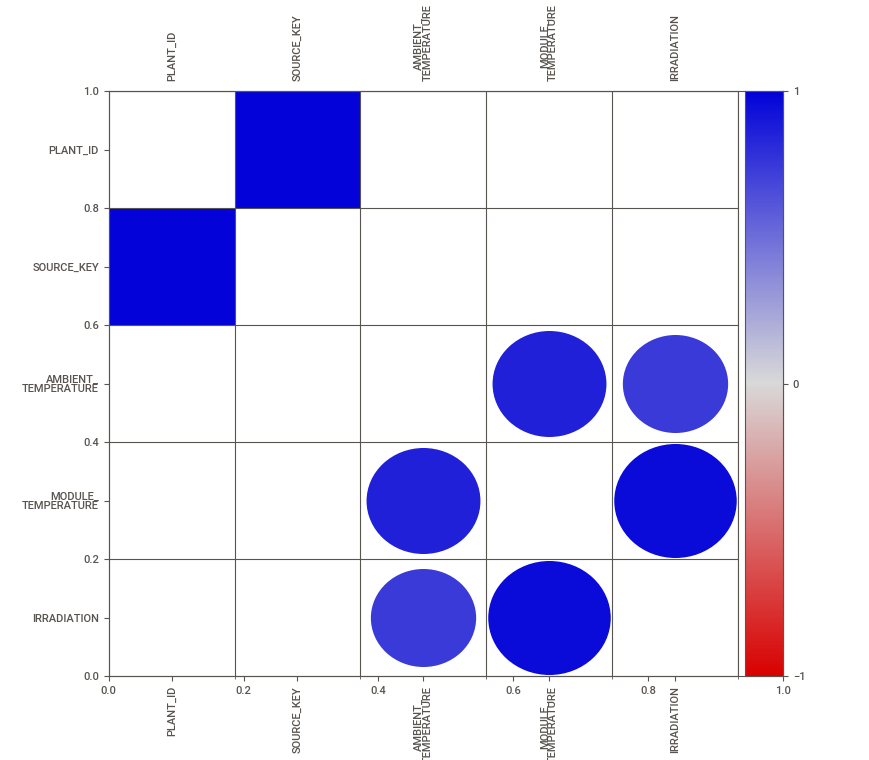
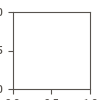

In [3]:
## Generate a Report for each dataset

report1 = sv.analyze(P_W1)
report1.show_html('sweetviz_report.html')
report1.show_notebook()

                                             |          | [  0%]   00:00 -> (? left)

Report sweetviz_report_2.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.



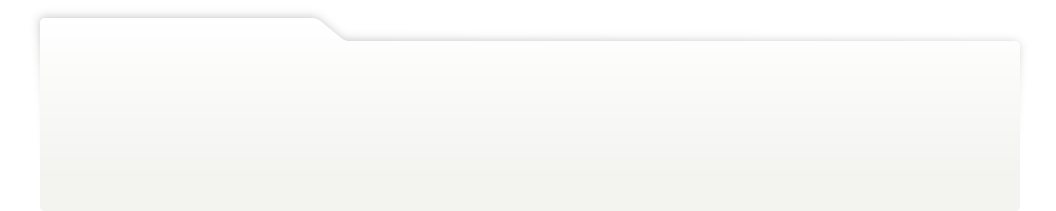
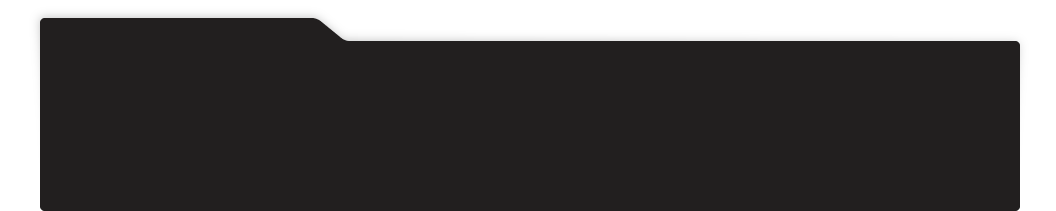
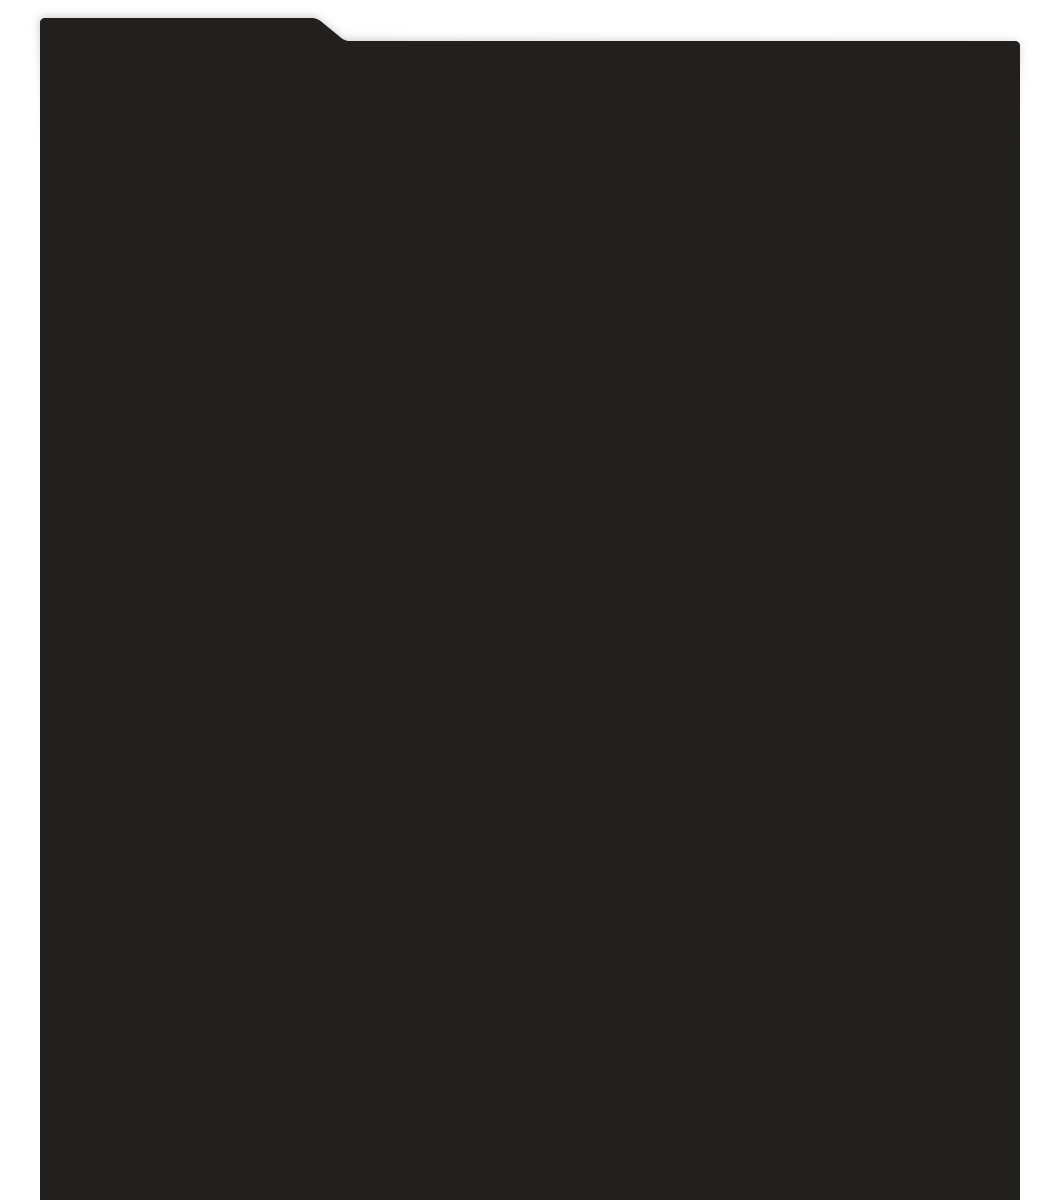
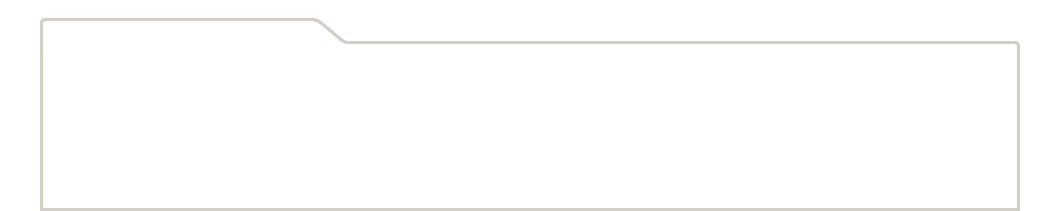
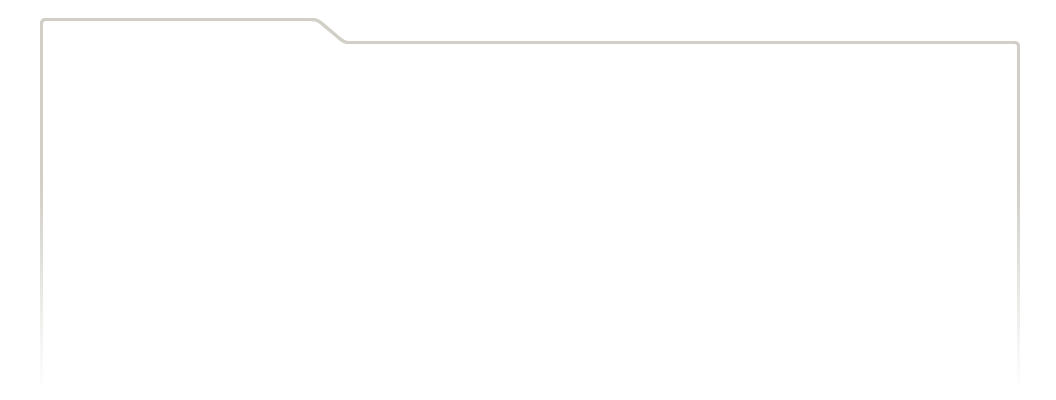
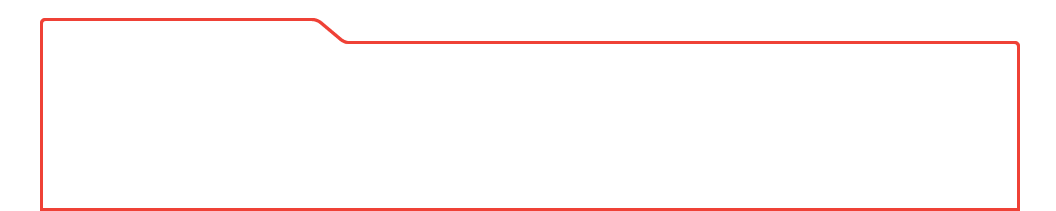
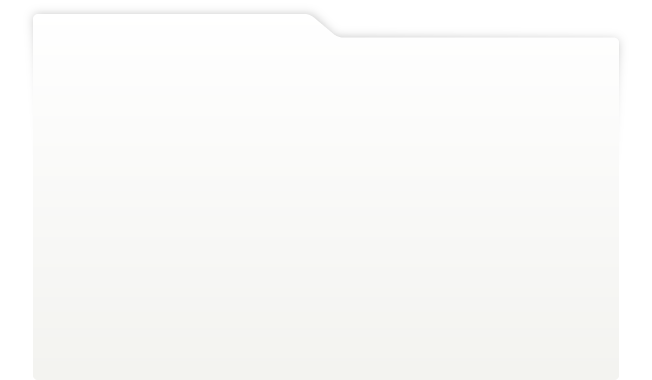
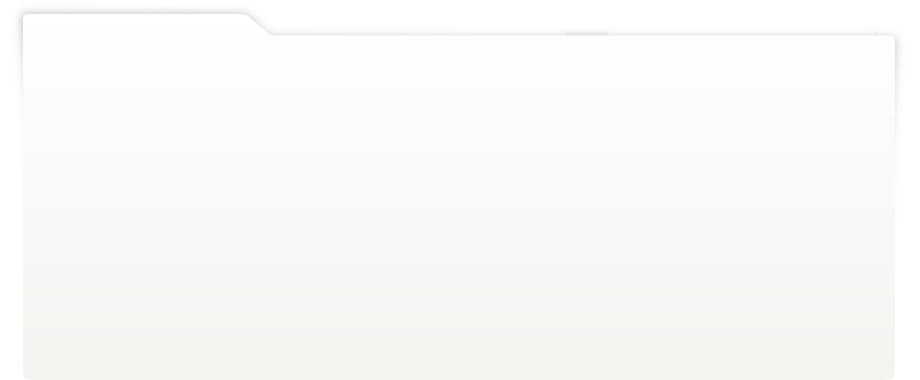
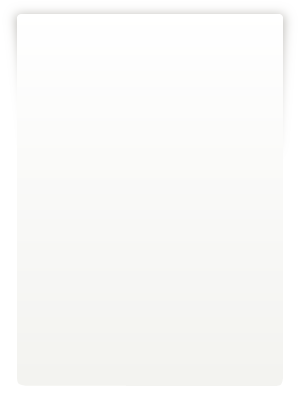
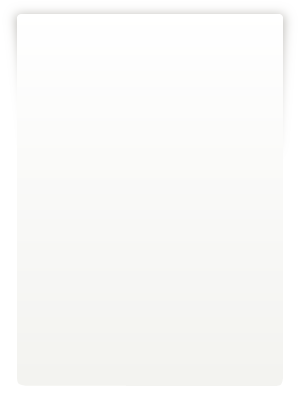
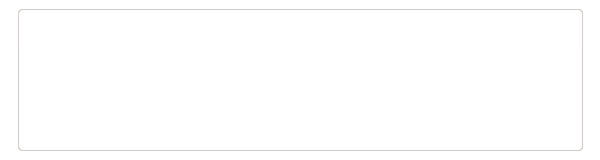
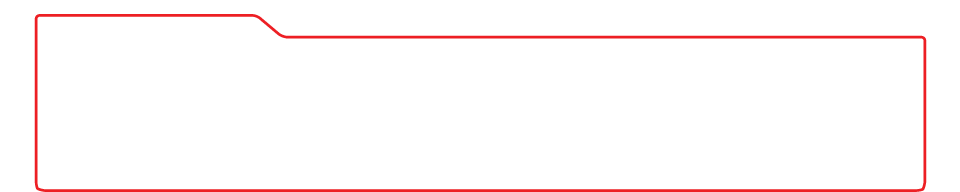
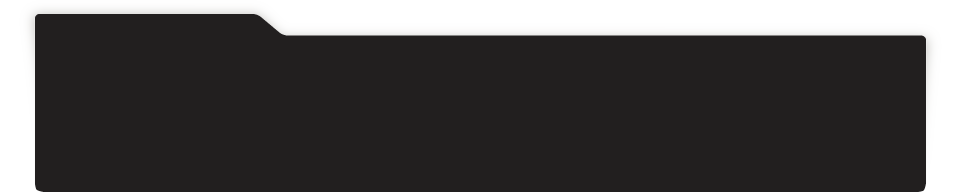
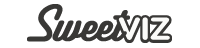
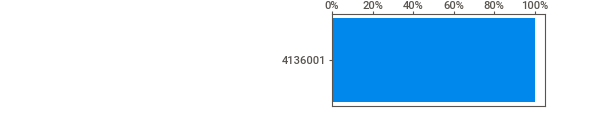
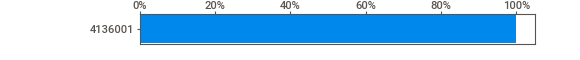
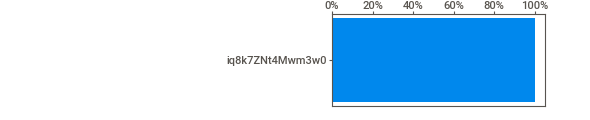
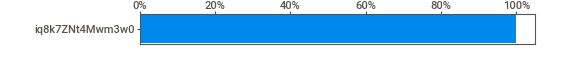
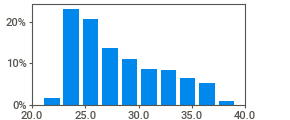
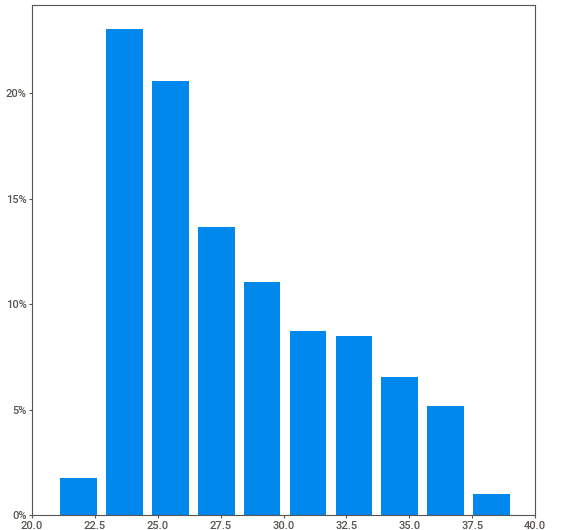
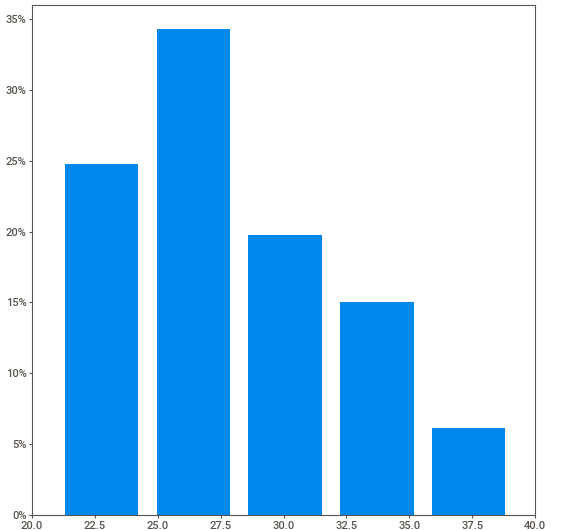
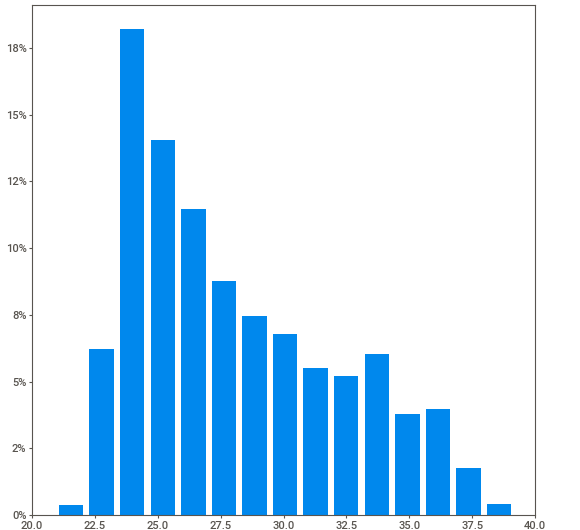
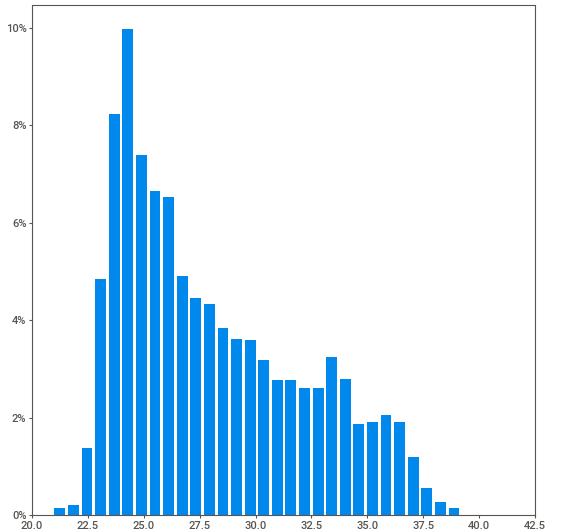
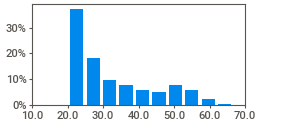
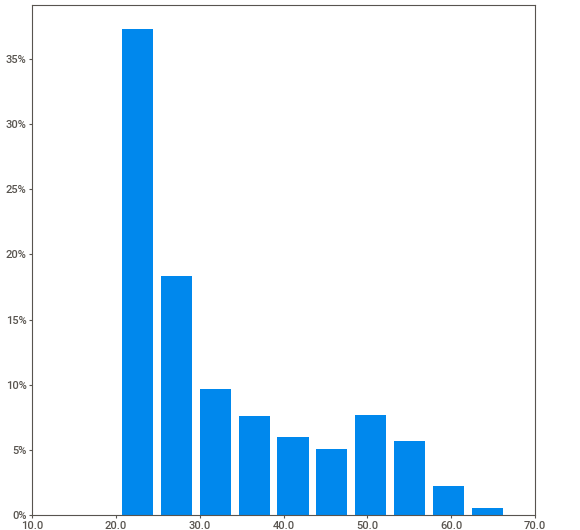
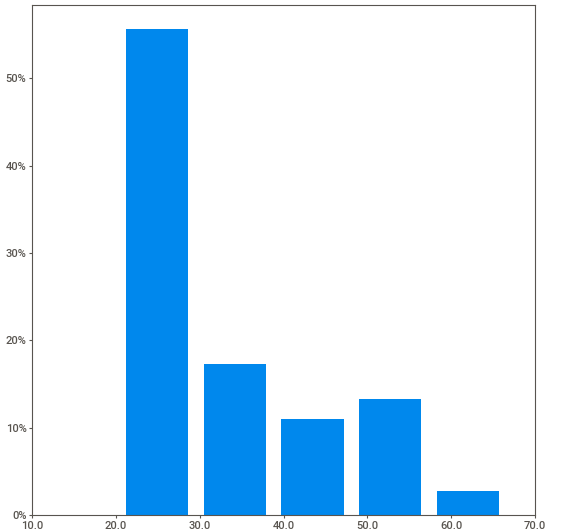
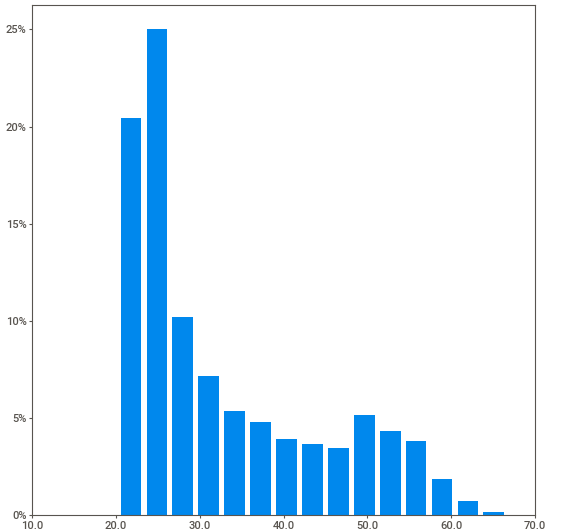
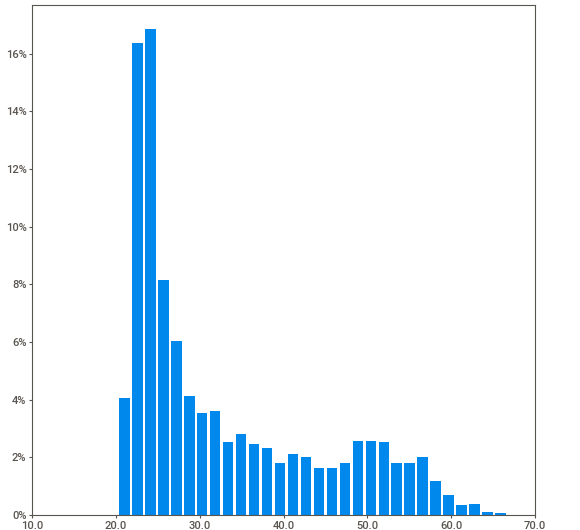
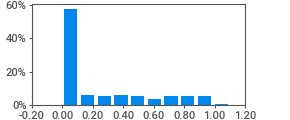
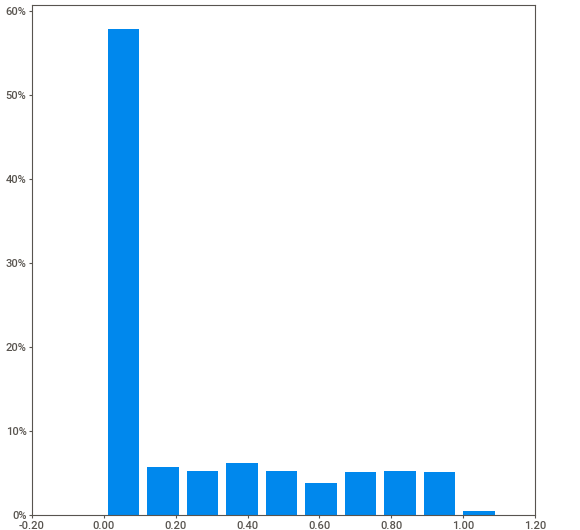
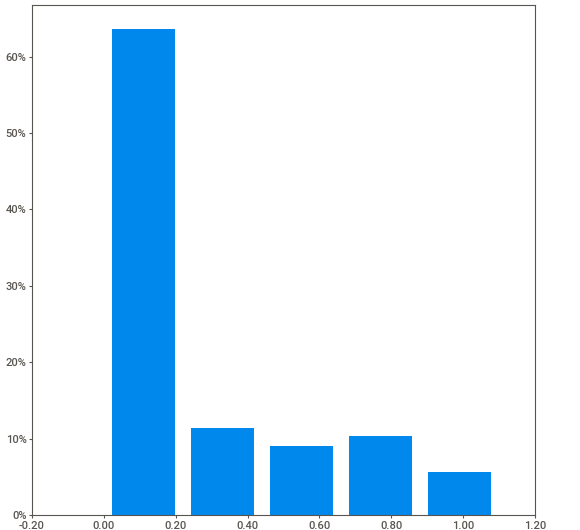
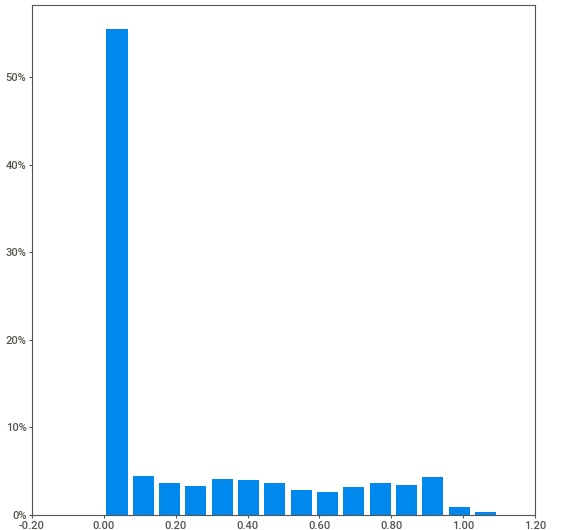
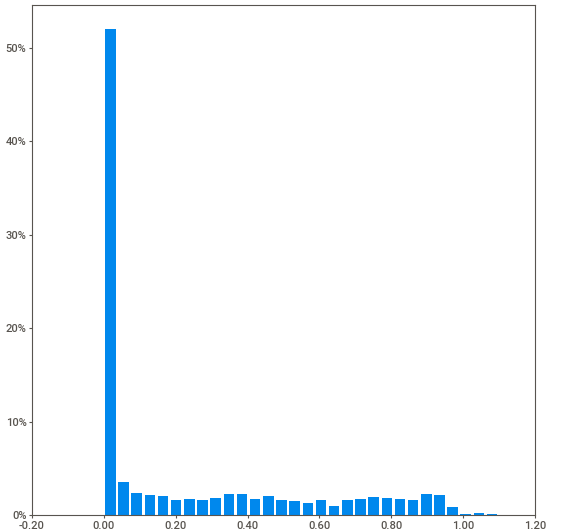
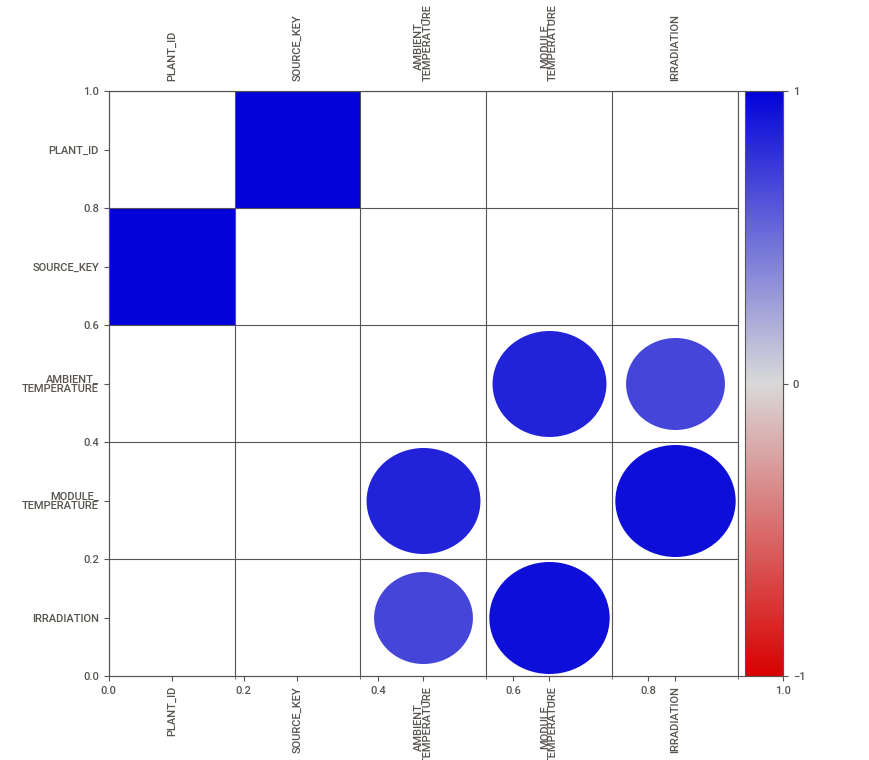
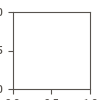

In [4]:
report2 = sv.analyze(P_W2)
report2.show_html('sweetviz_report_2.html')
report2.show_notebook()

In [5]:
## Drop Duplicates

P_W1.drop_duplicates()
P_W2.drop_duplicates()
P_G1.drop_duplicates()
P_G2.drop_duplicates()
print("All the duplicated values droped successfully")

All the duplicated values droped successfully


In [6]:
'''
The code ensures that the DATE_TIME columns in the four dataframes
(G1, S1, G2, S2) are properly formatted as pandas datetime objects for easier manipulation and analysis.
'''

P_G1['DATE_TIME'] = pd.to_datetime(P_G1['DATE_TIME'])
P_W1['DATE_TIME'] = pd.to_datetime(P_W1['DATE_TIME'])
P_G2['DATE_TIME'] = pd.to_datetime(P_G2['DATE_TIME'])
P_W2['DATE_TIME'] = pd.to_datetime(P_W2['DATE_TIME'])
print("DONE")

DONE


C:\Users\notsu\AppData\Local\Temp\ipykernel_11452\2823939008.py:6: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  P_G1['DATE_TIME'] = pd.to_datetime(P_G1['DATE_TIME'])


In [7]:
## Merge the data that came from the sensors with the generation data

df1 = pd.merge(P_G1.drop(columns = ['PLANT_ID']), P_W1.drop(columns = ['PLANT_ID', 'SOURCE_KEY']), on='DATE_TIME')

In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68774 entries, 0 to 68773
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE_TIME            68774 non-null  datetime64[ns]
 1   SOURCE_KEY           68774 non-null  object        
 2   DC_POWER             68774 non-null  float64       
 3   AC_POWER             68774 non-null  float64       
 4   DAILY_YIELD          68774 non-null  float64       
 5   TOTAL_YIELD          68774 non-null  float64       
 6   AMBIENT_TEMPERATURE  68774 non-null  float64       
 7   MODULE_TEMPERATURE   68774 non-null  float64       
 8   IRRADIATION          68774 non-null  float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 4.7+ MB


In [9]:
# Ensure DATE_TIME is in datetime format
df1["DATE_TIME"] = pd.to_datetime(df1["DATE_TIME"])

# Extract components from DATE_TIME
df1["DATE"] = df1["DATE_TIME"].dt.date
df1["TIME"] = df1["DATE_TIME"].dt.time
df1["DAY"] = df1["DATE_TIME"].dt.day
df1["MONTH"] = df1["DATE_TIME"].dt.month
df1["WEEK"] = df1["DATE_TIME"].dt.isocalendar().week
df1["HOURS"] = df1["DATE_TIME"].dt.hour
df1["MINUTES"] = df1["DATE_TIME"].dt.minute

# Add calculated columns
df1["TOTAL_MINUTES_PASS"] = df1["HOURS"] * 60 + df1["MINUTES"]
df1["DATE_STRING"] = df1["DATE"].astype(str)
df1["TIME"] = df1["TIME"].astype(str)

In [10]:
## encode from string to float
encoder = LabelEncoder()
df1['SOURCE_KEY_NUMBER'] = encoder.fit_transform(df1['SOURCE_KEY'])

## EDA

In [11]:
def plot_Days(data, rows, cols, title='Data'):
    cols_list = data.columns
    total_plots = len(cols_list)
    fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 4))
    fig.subplots_adjust(wspace=0.3, hspace=0.5)

    # Flatten the axes array for easier iteration
    axes = axes.flatten()

    i = 0
    while i < total_plots:
        ax = axes[i]
        data[cols_list[i]].plot(ax=ax, color='red')
        ax.set_title(f'{title}: {cols_list[i]}', color='blue', fontsize=10)
        ax.set_xlabel('Time', fontsize=9)
        ax.set_ylabel('Value', fontsize=9)
        i += 1

    # Hide any extra subplots if total_plots < rows * cols
    while i < len(axes):
        axes[i].axis('off')
        i += 1

    plt.show()

In [12]:
def plot_solar_data(df, date):
    # Filter data for the specified date
    data = df[df["DATE_STRING"].isin(date)]
    
    # If no data exists for the given date
    if data.empty:
        print(f"No data found for date: {date[0]}")
        return

    day = date[0]  # Extract date from the list
    plt.figure(figsize=(12, 12))
    
    # Plot DC Power Generation
    plt.subplot(3, 1, 1)
    sns.lineplot(x=data.DATE_TIME, y=data.DC_POWER, label="DC Power", color="green")
    plt.title(f"DC Power Generation: {day}")
    plt.xlabel("Date-Time")
    plt.ylabel("DC Power")
    plt.legend()

    # Plot Irradiation
    plt.subplot(3, 1, 2)
    sns.lineplot(x=data.DATE_TIME, y=data.IRRADIATION, label="Irradiation", color="green")
    plt.title(f"Irradiation: {day}")
    plt.xlabel("Date-Time")
    plt.ylabel("Irradiation")
    plt.legend()

    # Plot Ambient and Module Temperatures
    plt.subplot(3, 1, 3)
    sns.lineplot(x=data.DATE_TIME, y=data.AMBIENT_TEMPERATURE, label="Ambient Temperature", color="green")
    sns.lineplot(x=data.DATE_TIME, y=data.MODULE_TEMPERATURE, label="Module Temperature", color="blue")
    plt.title(f"Module & Ambient Temperature: {day}")
    plt.xlabel("Date-Time")
    plt.ylabel("Temperature")
    plt.legend()

    plt.tight_layout()
    plt.show()

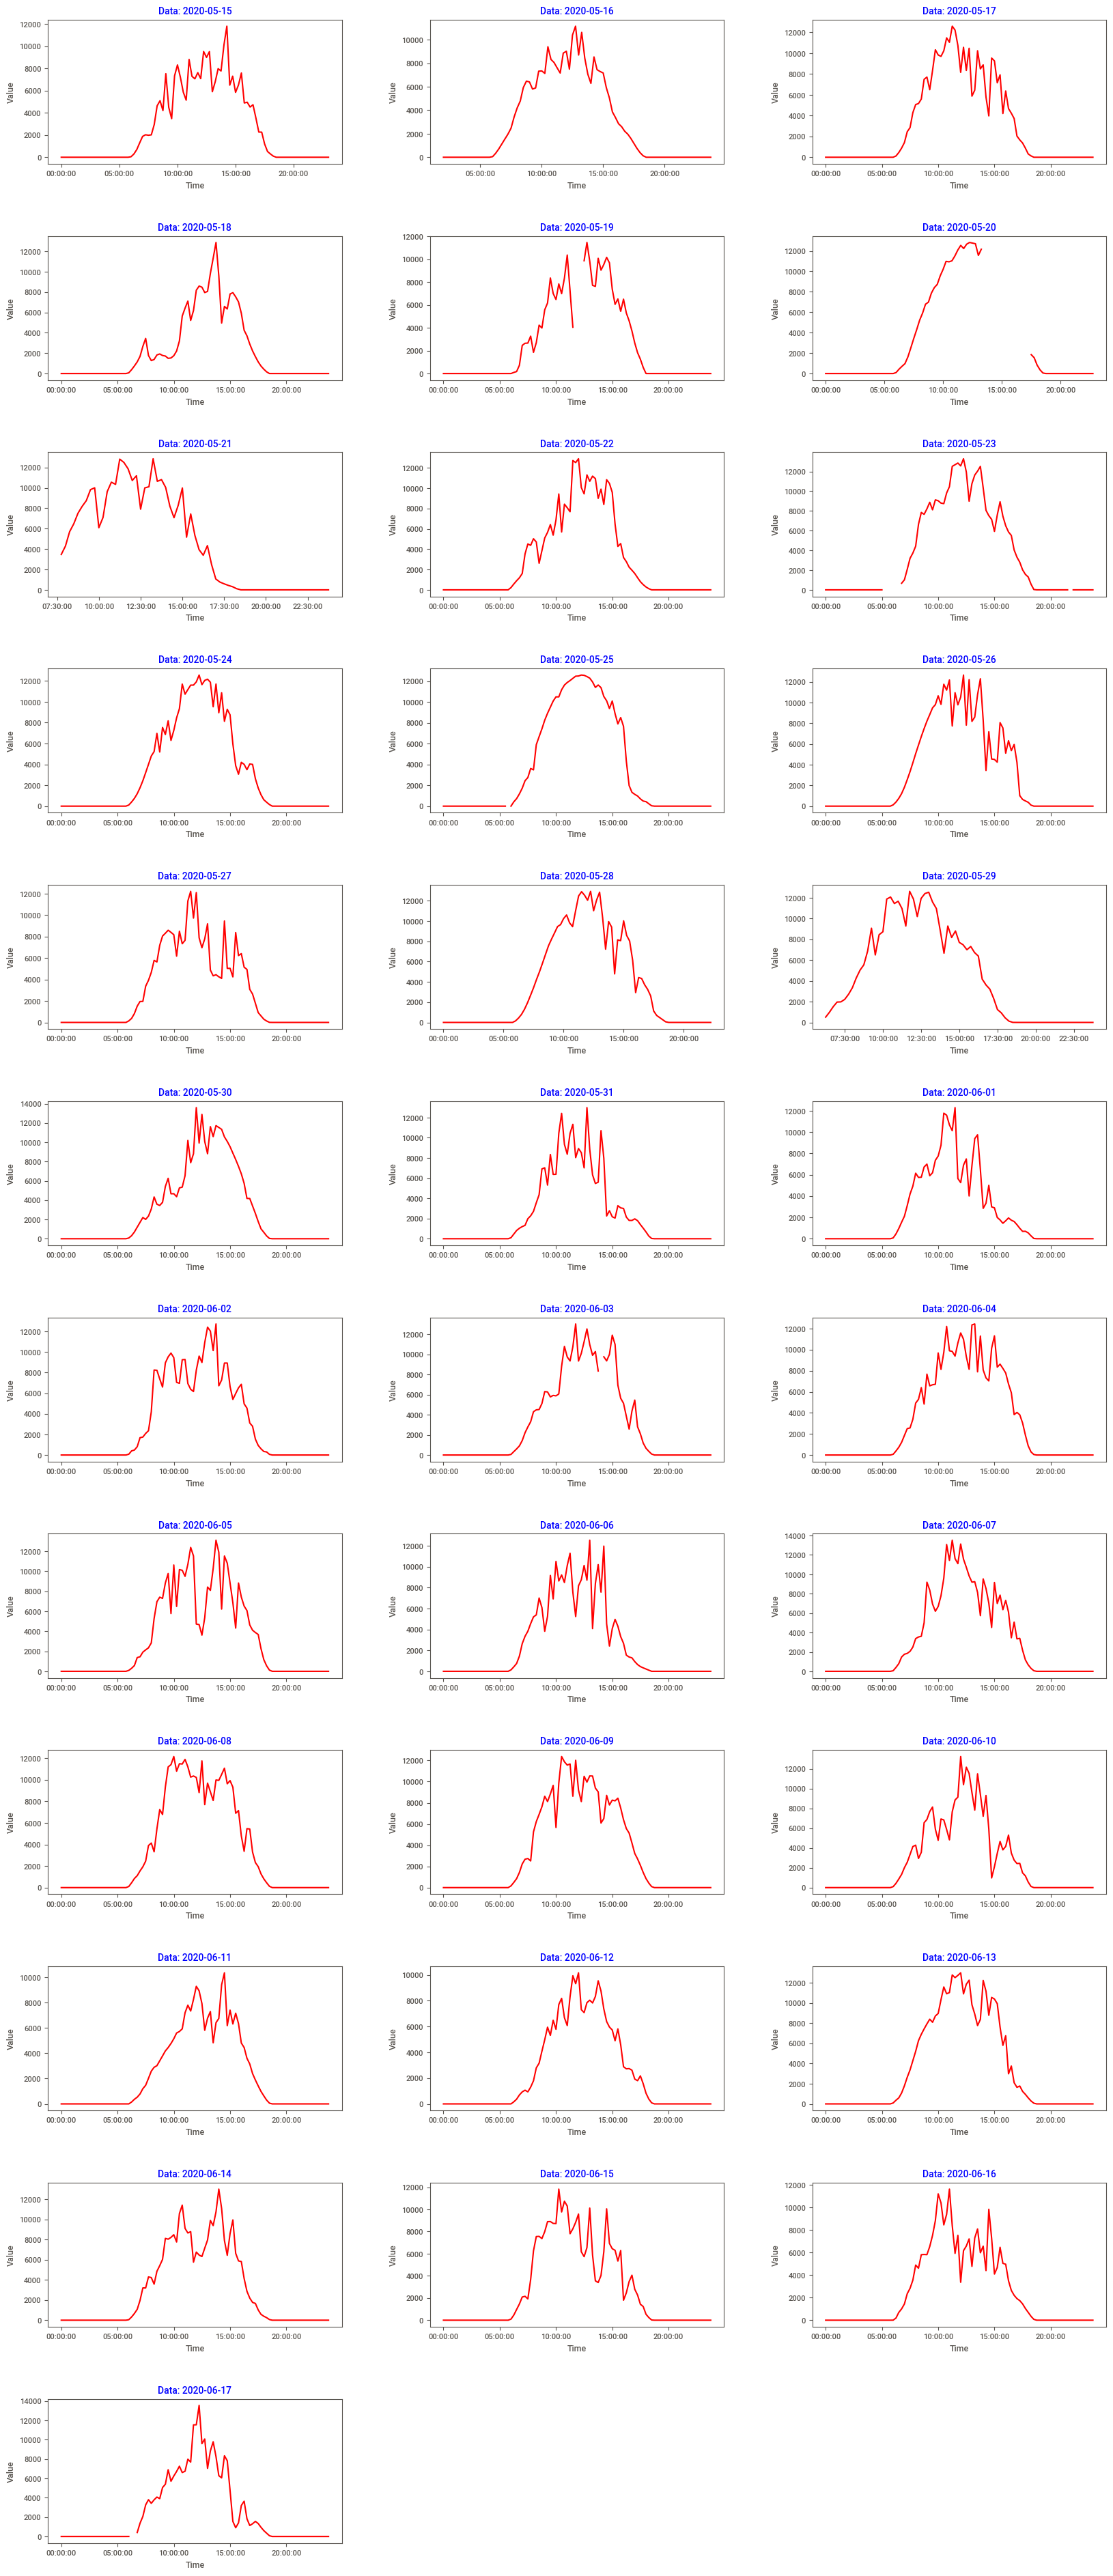

In [13]:
# Pivot table for solar DC power
DC_values = df1.pivot_table(values='DC_POWER', index='TIME', columns='DATE')
plot_Days(data=DC_values, rows=12, cols=3)

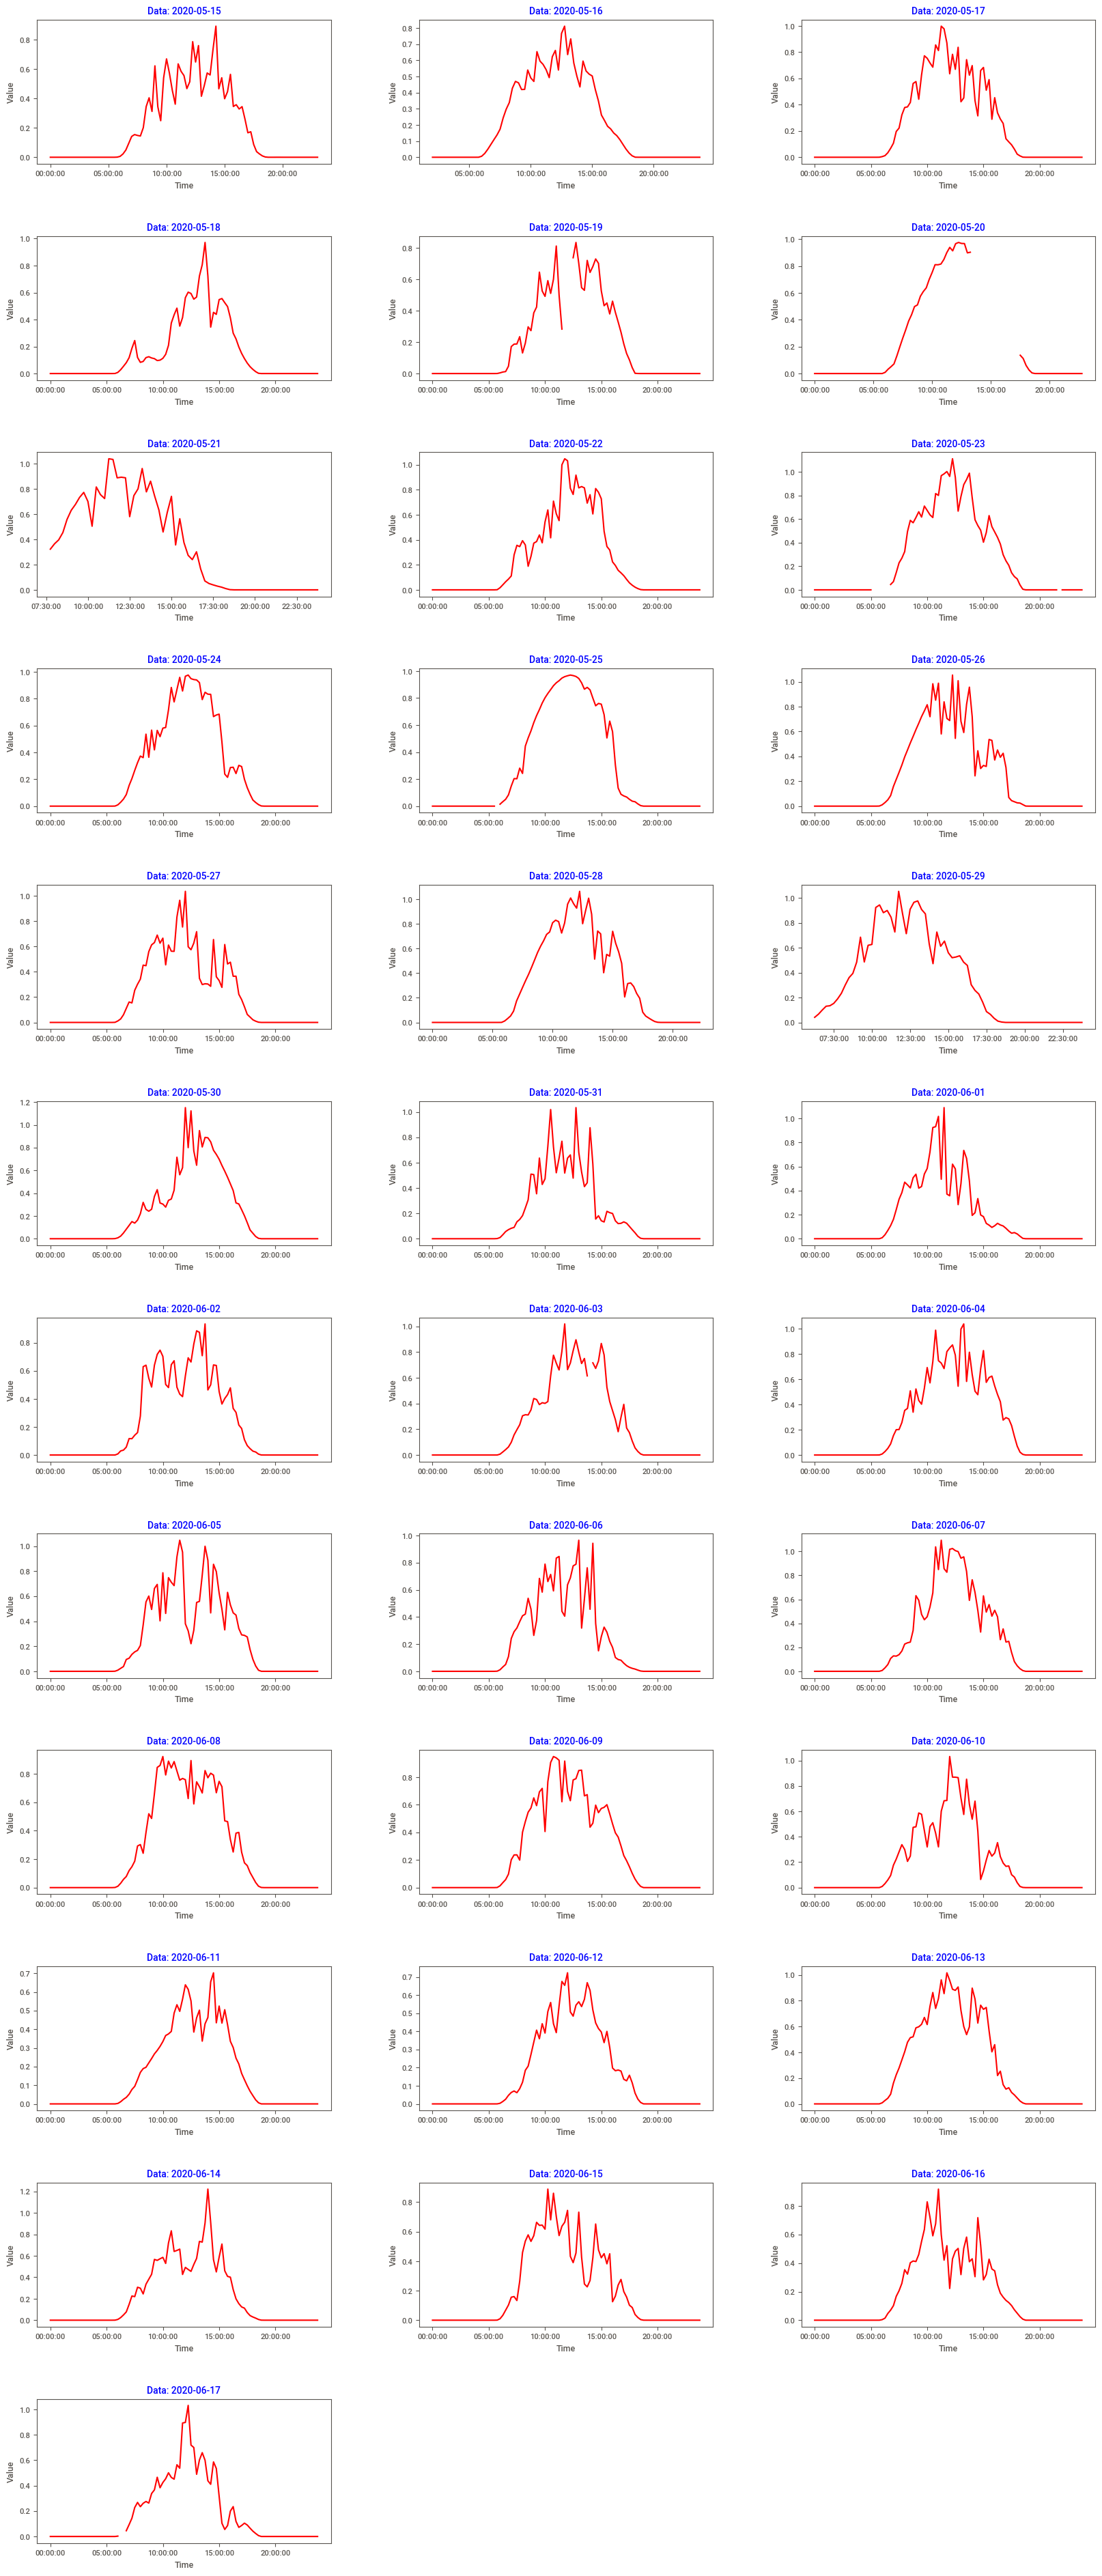

In [14]:
# Pivot table for solar irradiation
irradiation_values = df1.pivot_table(values='IRRADIATION', index='TIME', columns='DATE')
plot_Days(data=irradiation_values, rows=12, cols=3)

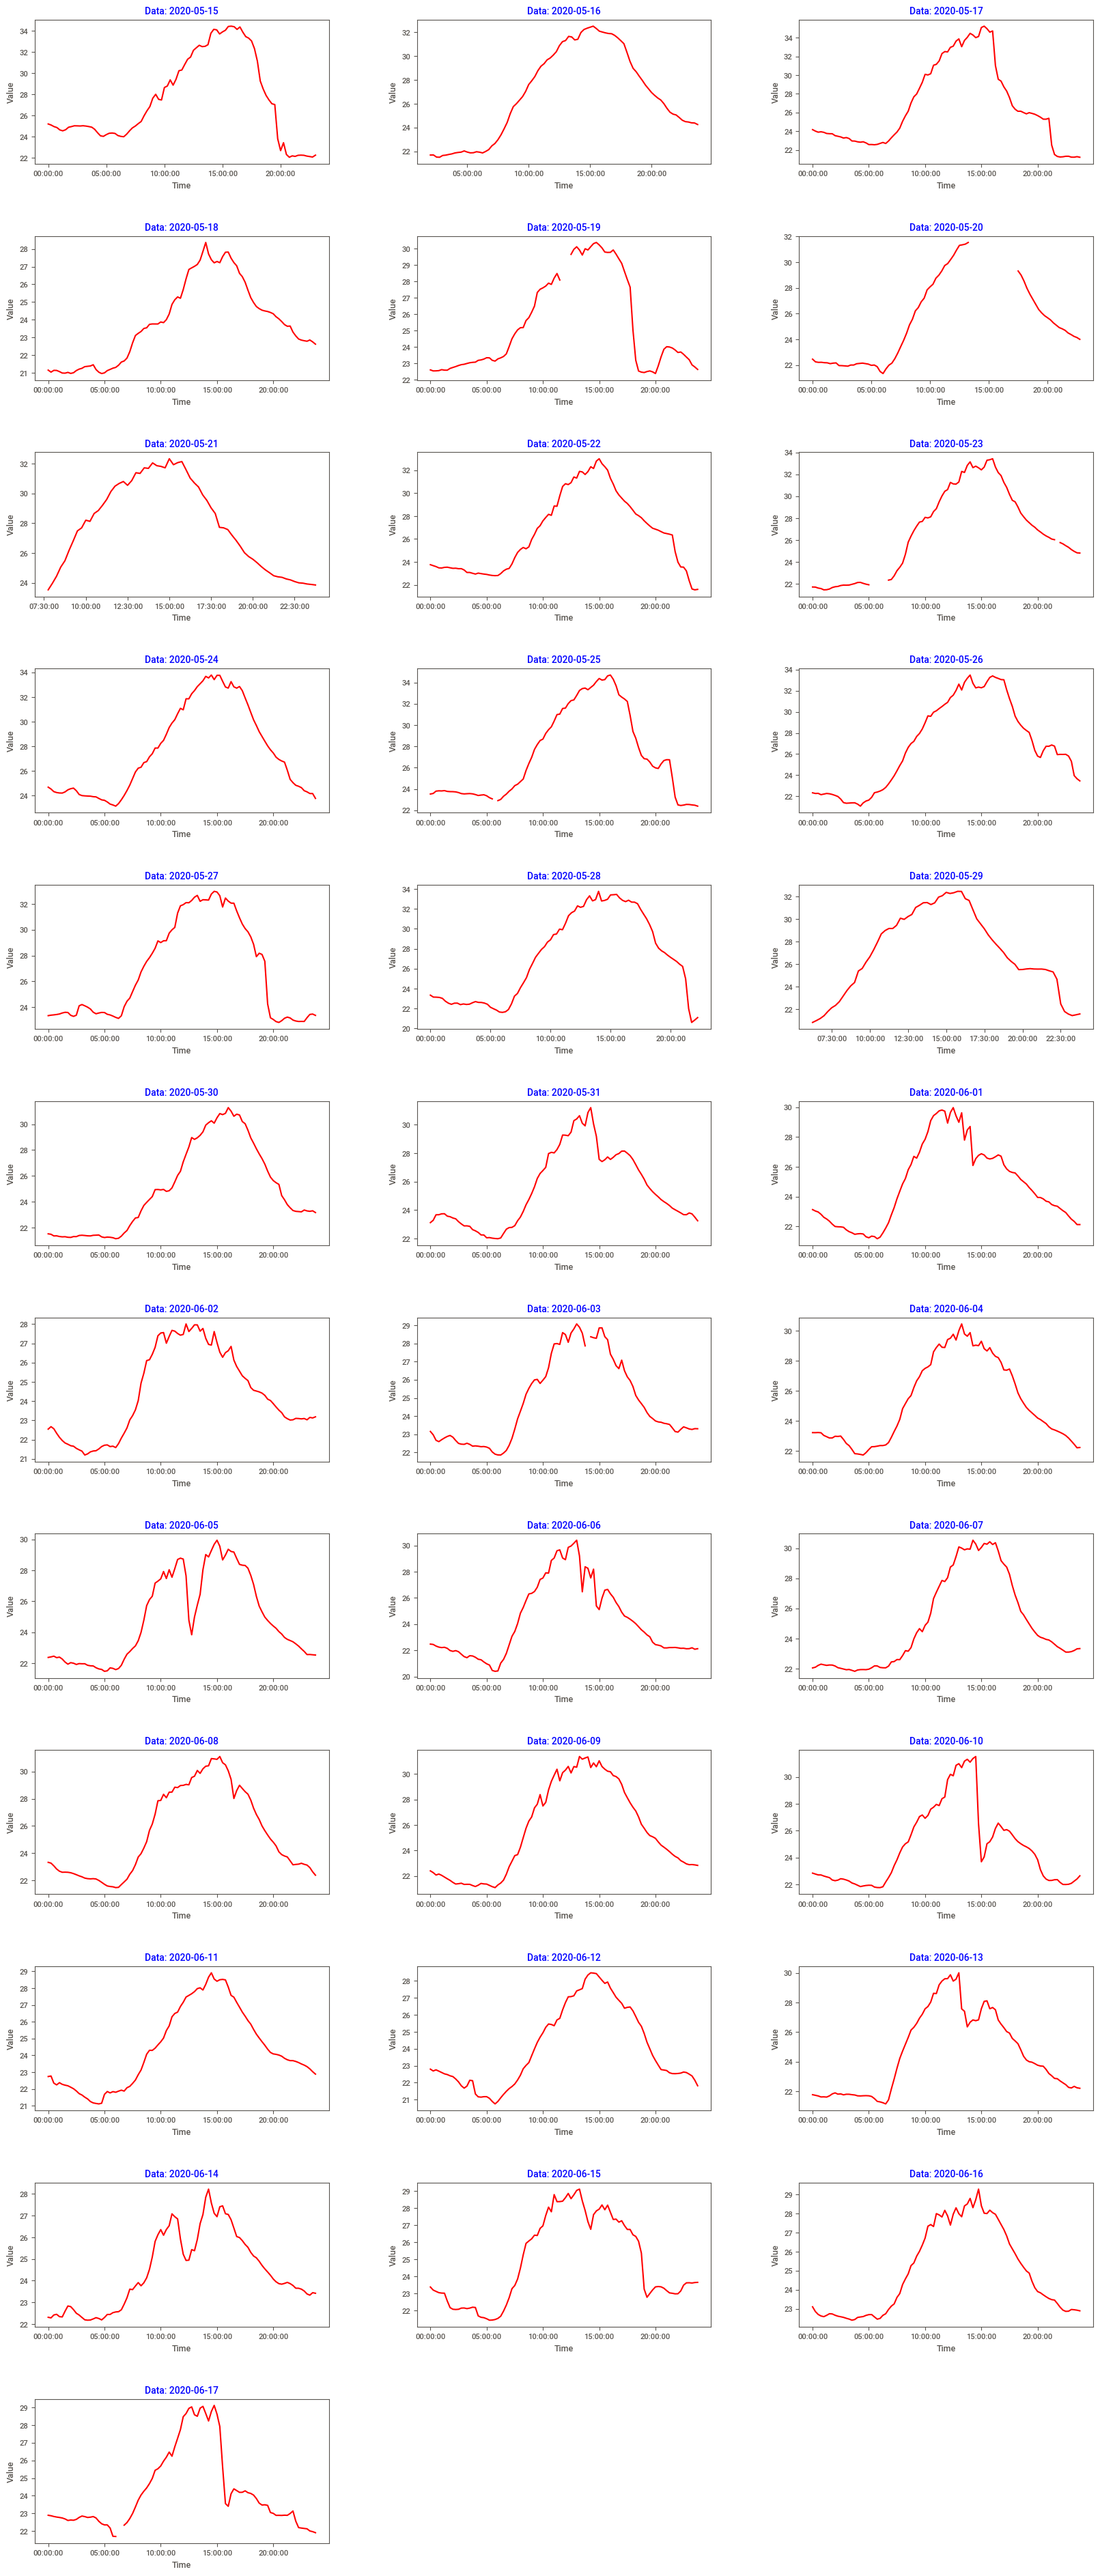

In [15]:
# Pivot table for temp
ambiant_temp = df1.pivot_table(values='AMBIENT_TEMPERATURE', index='TIME', columns='DATE')
plot_Days(data=ambiant_temp, rows=12, cols=3)

Enter the Date (YYYY-MM-DD):  2020-05-15


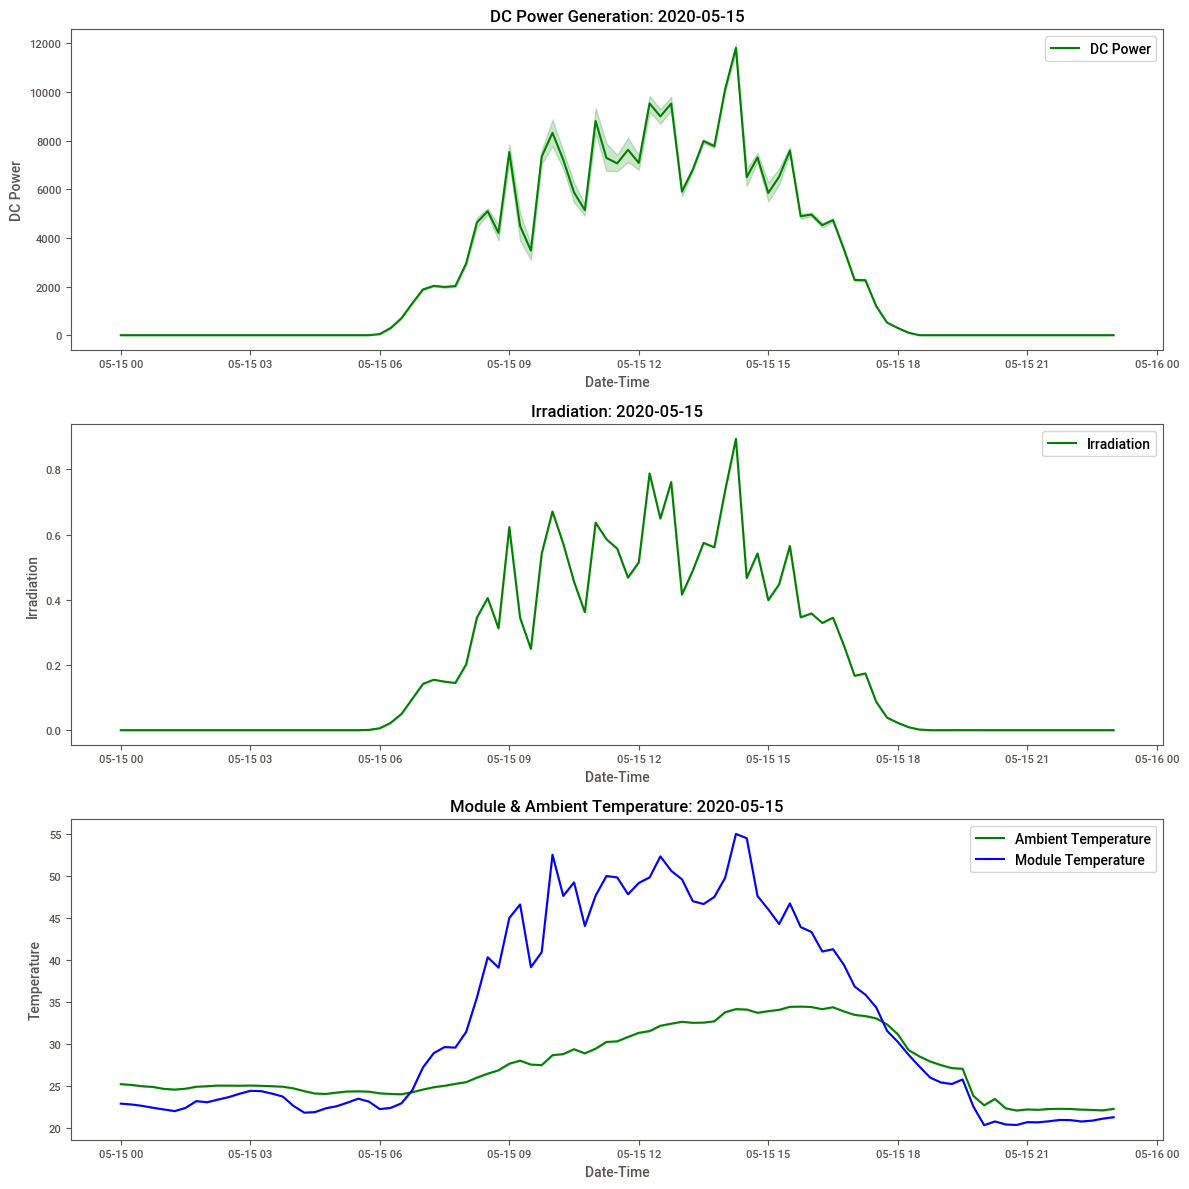

In [16]:
date_input = input("Enter the Date (YYYY-MM-DD): ").strip()
plot_solar_data(df1, [date_input])

## Data Preprocessing

In [17]:
## Data Preprocessing

def preprocess_data(df, target_column=None, z_threshold=3):
    # 1. Handle missing values: Drop rows with NaN or impute with the mean
    df_clean = df.dropna()  
    # 2. Remove outliers: Using Z-score method
    if z_threshold:
        numeric_cols = df_clean.select_dtypes(include=np.number).columns
        z_scores = np.abs((df_clean[numeric_cols] - df_clean[numeric_cols].mean()) / df_clean[numeric_cols].std())
        df_clean = df_clean[(z_scores < z_threshold).all(axis=1)]
    return df_clean

In [18]:
df_clean = preprocess_data(df1, target_column='AC_POWER')

## Transformer with Ridge Reg.

In [19]:
from sklearn.metrics import mean_squared_error, r2_score

class RidgeRegressionPipeline:
    def __init__(self, alpha=1.0, solver="auto", max_iter=None, tol=1e-3):
        self.alpha = alpha
        self.solver = solver
        self.max_iter = max_iter
        self.tol = tol
        self.preprocessor = None
        self.model = Ridge(alpha=self.alpha, solver=self.solver, max_iter=self.max_iter, tol=self.tol)

    def build_preprocessor(self, X):
        """
        Builds the preprocessor for standardizing the numerical features.
        """
        numerical_features = X.select_dtypes(include=["float64", "int64"]).columns
        self.preprocessor = ColumnTransformer(
            transformers=[
                ("num", StandardScaler(), numerical_features)
            ]
        )

    def fit(self, X_train, y_train):
        """
        Fits the Ridge model using standardized data.
        """
        if self.preprocessor is None:
            self.build_preprocessor(X_train)
        # Fit the preprocessor and transform the training data
        X_train_scaled = self.preprocessor.fit_transform(X_train)
        # Fit the Ridge model on the standardized training data
        self.model.fit(X_train_scaled, y_train)

    def predict(self, X_test):
        """
        Predicts the target using the standardized test data.
        """
        if self.preprocessor is None:
            raise ValueError("The preprocessor has not been built or fitted yet.")
        # Transform the test data using the fitted preprocessor
        X_test_scaled = self.preprocessor.fit_transform(X_test)
        # Predict using the Ridge model
        return self.model.predict(X_test_scaled)

    def evaluate(self, X_test, y_test):
        """
        Evaluates the model on test data using MSE and R².
        :param X_test: Test features.
        :param y_test: True target values for the test data.
        :return: Tuple (MSE, R²)
        """
        y_pred = self.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        return mse, r2

    def visualize_results(self, X_test, y_test):
        """
        Visualizes the actual vs. predicted values and residuals.
        """
        y_pred = self.predict(X_test)

        # Scatter plot of actual vs predicted values
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, y_pred, alpha=0.7, edgecolor="k")
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
        plt.xlabel("Actual Values")
        plt.ylabel("Predicted Values")
        plt.title("Actual vs Predicted Values")
        plt.grid(True)
        plt.show()

        # Residual plot
        residuals = y_test - y_pred
        plt.figure(figsize=(10, 6))
        plt.scatter(y_pred, residuals, alpha=0.7, edgecolor="k")
        plt.axhline(y=0, color="r", linestyle="--", lw=2)
        plt.xlabel("Predicted Values")
        plt.ylabel("Residuals")
        plt.title("Residuals vs Predicted Values")
        plt.grid(True)
        plt.show()

In [20]:
X = df_clean[['DAILY_YIELD','TOTAL_YIELD','AMBIENT_TEMPERATURE','MODULE_TEMPERATURE','IRRADIATION','DC_POWER']]
y = df_clean['AC_POWER']

In [21]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

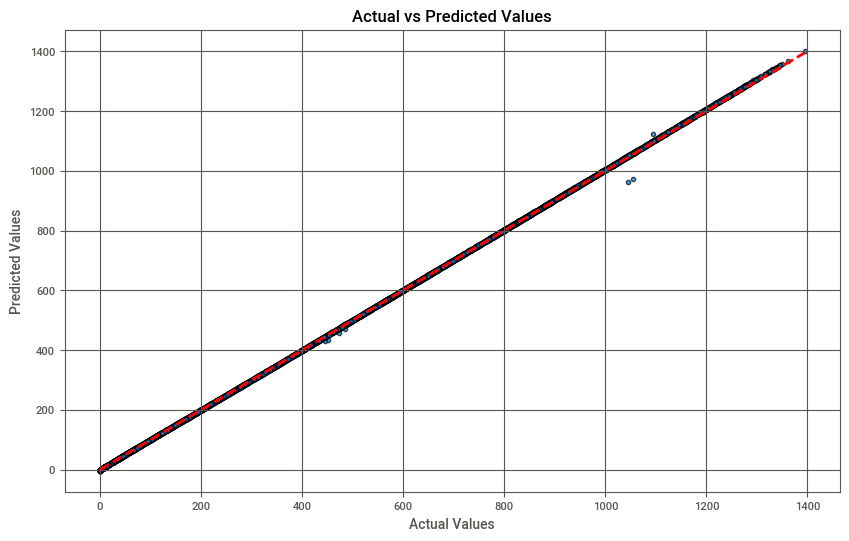

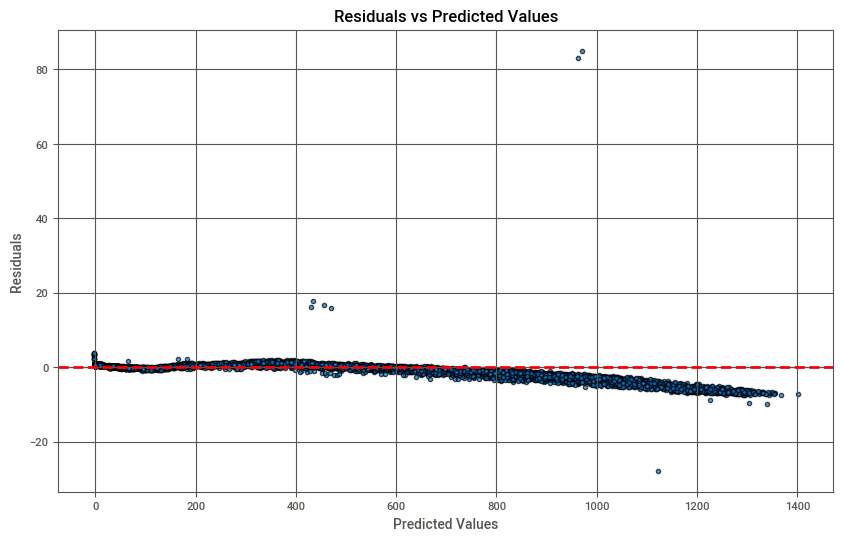

In [22]:
# Initialize the pipeline
ridge_pipeline = RidgeRegressionPipeline(alpha=0.0001, solver="saga", max_iter=1000, tol=1e-4)

# Fit the model
ridge_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = ridge_pipeline.predict(X_test)

# Visualize the results
ridge_pipeline.visualize_results(X_test, y_test)

In [23]:
mse, r2 = ridge_pipeline.evaluate(X_test, y_test)
print(mse,r2)

4.400175413554426 0.9999714255021417


## Testing The Model

In [24]:
df2 = pd.merge(P_G2.drop(columns = ['PLANT_ID']), P_W2.drop(columns = ['PLANT_ID', 'SOURCE_KEY']), on='DATE_TIME')

In [25]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67698 entries, 0 to 67697
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE_TIME            67698 non-null  datetime64[ns]
 1   SOURCE_KEY           67698 non-null  object        
 2   DC_POWER             67698 non-null  float64       
 3   AC_POWER             67698 non-null  float64       
 4   DAILY_YIELD          67698 non-null  float64       
 5   TOTAL_YIELD          67698 non-null  float64       
 6   AMBIENT_TEMPERATURE  67698 non-null  float64       
 7   MODULE_TEMPERATURE   67698 non-null  float64       
 8   IRRADIATION          67698 non-null  float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 4.6+ MB


In [26]:
df_clean_2 = preprocess_data(df2, target_column=None)

In [27]:
testing =df_clean_2[['DAILY_YIELD','TOTAL_YIELD','AMBIENT_TEMPERATURE','MODULE_TEMPERATURE','IRRADIATION','DC_POWER']]

In [29]:
y_True = df_clean_2['AC_POWER']

In [35]:
prediction = ridge_pipeline.predict(testing)

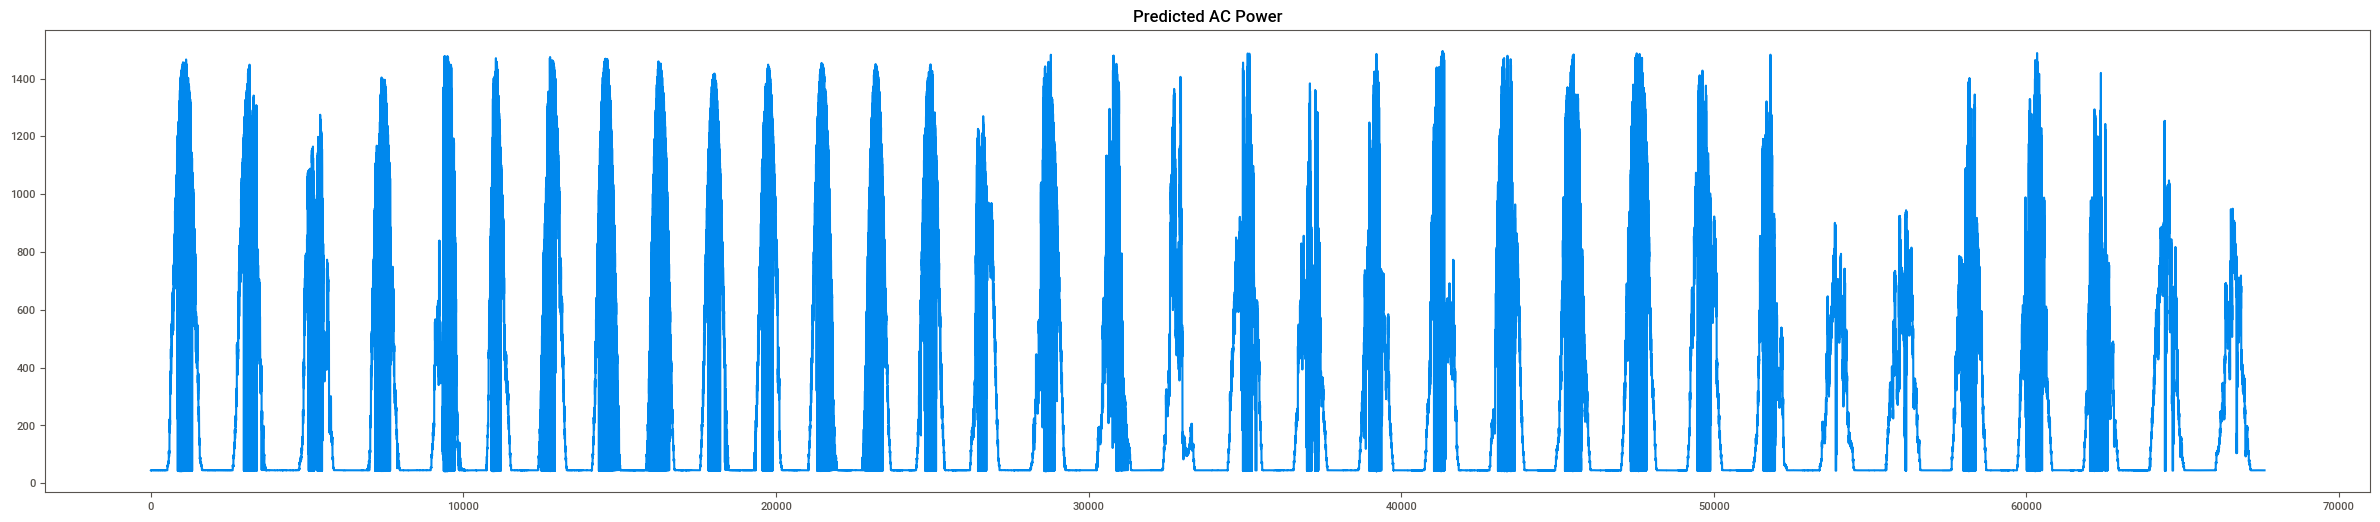

In [36]:
plt.figure(figsize=(30,6))
plt.plot(prediction)
plt.title("Predicted AC Power")
plt.show()

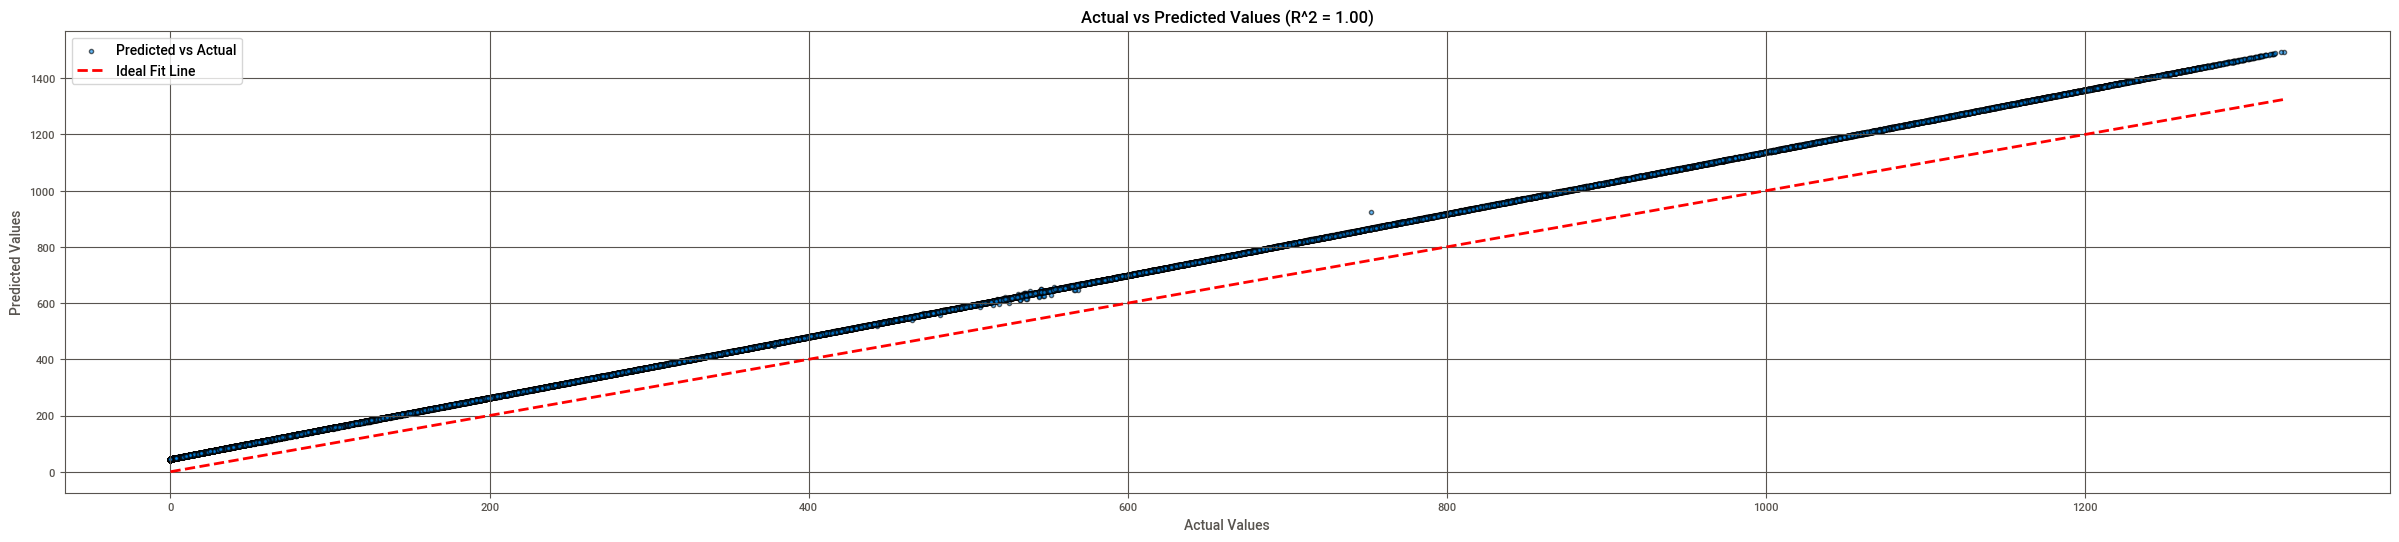

In [37]:
# Plot actual vs predicted values
plt.figure(figsize=(30, 6))
plt.scatter(y_True, prediction, alpha=0.6, edgecolor='k', label='Predicted vs Actual')
plt.plot([y_True.min(), y_True.max()], [y_True.min(), y_True.max()], 'r--', lw=2, label='Ideal Fit Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Actual vs Predicted Values (R^2 = {r2:.2f})')
plt.legend()
plt.grid()
plt.show()